# Transient Profile Generator and tracking differentiator

## Set-up problem

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
#%matplotlib widget

In [2]:
N = 1000  #i.e. 25Hz
time = np.linspace(0,40,N)
target = np.zeros((N,)); 
targetd = np.zeros((N,)); 
amplitude = 1.6;
target[N//6:] = 1.0
target[N//4:] = amplitude*np.sin(0.5*time[N//4:])
targetd[N//4:] = amplitude*0.5*np.cos(0.5*time[N//4:])
maxacc = 1;
maxvel =0.7;

## Continuous case

In [3]:
y = np.zeros((N,))
yd = np.zeros((N,))

dt = time[1]-time[0]
for i in range(N-1):
    y[i+1]  = y[i] + yd[i]*dt
    tmp = y[i] - target[i] + yd[i] * math.fabs(yd[i]) / 2 / maxacc; 
    if (tmp < 0):
        s = -1;
    elif (tmp > 0):
        s = 1;
    else :
        s = 0;
    u = -maxacc*s
    yd[i+1] = yd[i] + u * dt 

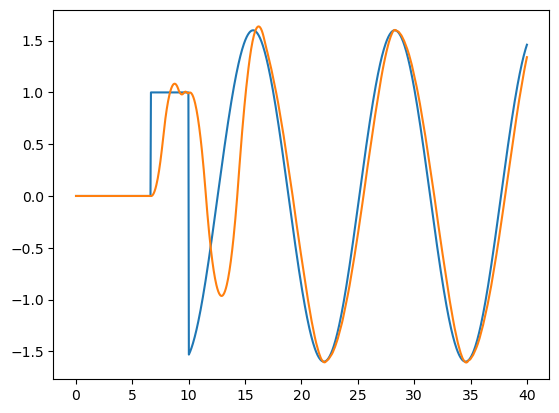

In [4]:
plt.figure(1);
plt.plot(time,target);
plt.plot(time,y)
y_cont = y
yd_cont = yd

## Discrete Case

In [5]:
def sgn(a):
    if a < 0:
        return -1
    elif a > 0:
        return 1
    else:
        return 0;

def fhan(v1,v2,r0,h0):
    d  = h0*r0*r0
    a0 = h0*v2
    y  = v1 + a0
    a1 = math.sqrt( d*( d + 8*math.fabs(y)) )
    a2 = a0 + sgn(y)*(a1-d)/2
    sy = ( sgn(y+d)-sgn(y-d)) /2
    a  = (a0 + y - a2)*sy + a2
    sa = (sgn(a+d) - sgn(a-d))/2
    return - r0* (a/d - sgn(a))*sa - r0*sgn(a)
    
    
def fst( x1,x2, r, h) :
    d  = r*h
    d0 = d*h
    y  = x1 + h*x2
    ya = math.fabs(y)
    a0 = math.sqrt( d*d + 8*r*ya ) 
    if ya > d0:
        a = x2 + (a0-d)/2*sgn(y)
    else:
        a = x2 + y / h
    if math.fabs(a) > d:
        return - r*sgn(a)
    else:
        return - r*a/d

    
y = np.zeros((N,))
yd = np.zeros((N,))

dt = time[1]-time[0]
for i in range(N-1):
    y[i+1]  = y[i] + yd[i]*dt
    u = fst( y[i] - target[i], yd[i], maxacc, dt)
    yd[i+1] = yd[i] + u * dt 

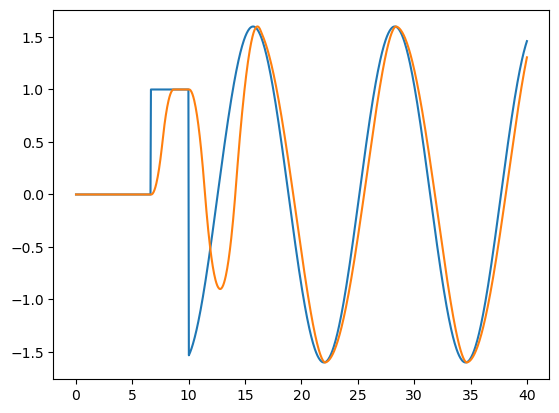

In [6]:
plt.figure(2);
plt.plot(time,target);
plt.plot(time,y)
#plt.plot(time,y_cont)

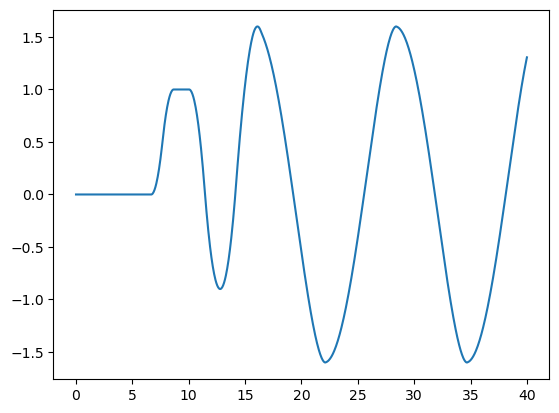

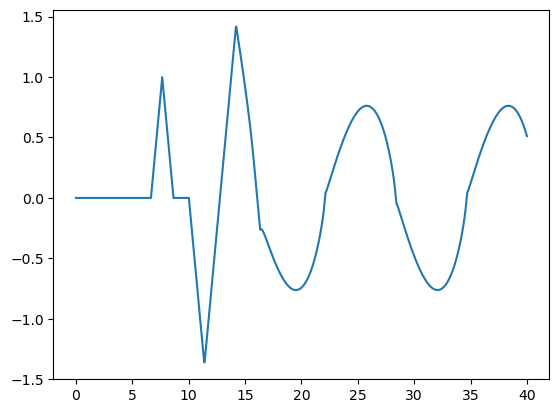

In [7]:
plt.figure(3);
plt.plot(time,y);
plt.figure(4);
plt.plot(time,yd);

## Discrete case with velocity limits, including velocity targets

Second part of the target curve now contains non-zero velocity targets

In [8]:
def sgn(a):
    if a < 0:
        return -1
    elif a > 0:
        return 1
    else:
        return 0;

def fhan(v1,v2,r0,h0):
    d  = h0*r0*r0
    a0 = h0*v2
    y  = v1 + a0
    a1 = math.sqrt( d*( d + 8*math.fabs(y)) )
    a2 = a0 + sgn(y)*(a1-d)/2
    sy = ( sgn(y+d)-sgn(y-d)) /2
    a  = (a0 + y - a2)*sy + a2
    sa = (sgn(a+d) - sgn(a-d))/2
    return - r0* (a/d - sgn(a))*sa - r0*sgn(a)
    
    
def fst( x1,x2, r, h) :
    d  = r*h
    d0 = d*h
    y  = x1 + h*x2
    ya = math.fabs(y)
    a0 = math.sqrt( d*d + 8*r*ya ) 
    if ya > d0:
        a = x2 + (a0-d)/2*sgn(y)
    else:
        a = x2 + y / h
    if math.fabs(a) > d:
        return - r*sgn(a)
    else:
        return - r*a/d

    
y = np.zeros((N,))
yd = np.zeros((N,))
u  = np.zeros((N,))
dt = time[1]-time[0]
for i in range(N-1):
    y[i+1]  = y[i] + yd[i]*dt
    u[i] = fst( y[i] - target[i], yd[i] - targetd[i], maxacc, dt)
    new_yd = yd[i] + u[i] * dt 
    if new_yd <= - maxvel:
        u[i] = (-maxvel-yd[i])/dt
        new_yd = -maxvel
    if new_yd >= maxvel:
        u[i] = (maxvel-yd[i])/dt
        new_yd = maxvel
    yd[i+1] = new_yd

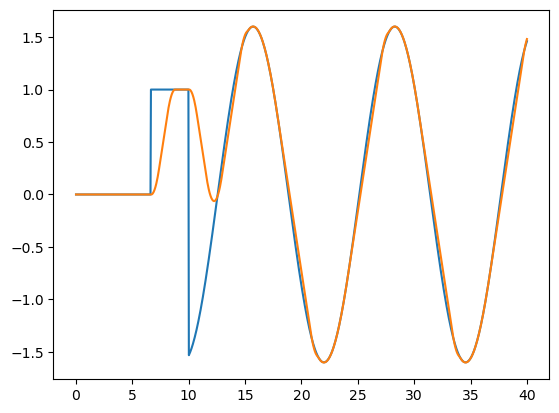

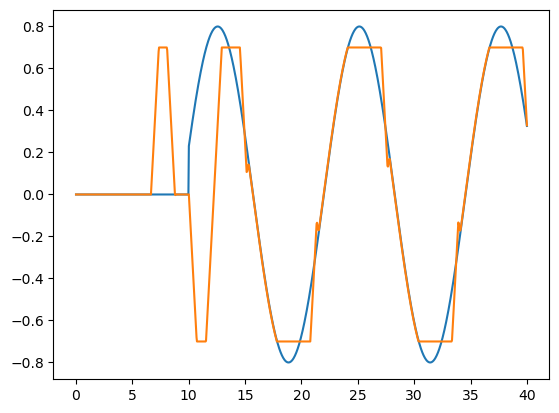

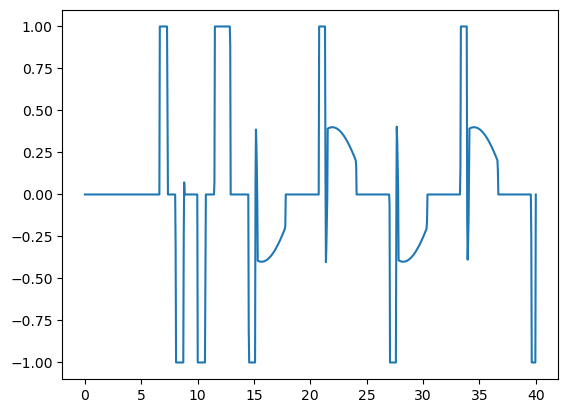

In [9]:

plt.figure(5);
plt.plot(time,target);
plt.plot(time,y);
plt.figure(6);
plt.plot(time,targetd);
plt.plot(time,yd);
plt.figure(7);
plt.plot(time,u);
plt.show()

## Analyzing the fst function

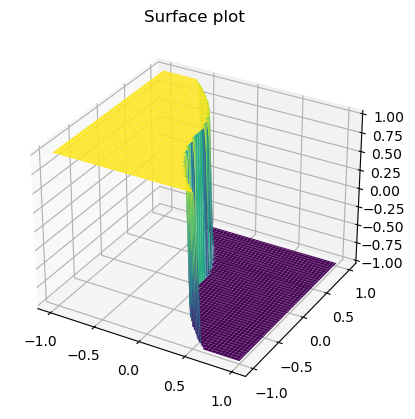

In [10]:
M = 100
x1i = np.linspace(-1,1,M)
x2i = np.linspace(-1,1,M)
X1, X2 = np.meshgrid(x1i, x2i)
Z = X1.copy()
for i in range(M):
    for j in range(M):
        Z[i,j] = fst( X1[i,j], X2[i,j], maxacc, dt)
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(X1,X2,Z,cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
plt.show()

## Defining the obtained procedure in a useable routine

In [11]:
def sgn(a):
    if a < 0:
        return -1
    elif a > 0:
        return 1
    else:
        return 0;   
    
def fst( x1,x2, r, h) :
    d  = r*h
    d0 = d*h
    y  = x1 + h*x2
    ya = math.fabs(y)
    a0 = math.sqrt( d*d + 8*r*ya ) 
    if ya > d0:
        a = x2 + (a0-d)/2*sgn(y)
    else:
        a = x2 + y / h
    if math.fabs(a) > d:
        return - r*sgn(a)
    else:
        return - r*a/d


def transientprofilegenerator(y,yd, target, targetd, maxvel, maxacc, dt):
    """returns y,yd,u, the next y, yd and control signal (acceleration) u """
    u = fst( y - target, yd - targetd, maxacc, dt)
    new_y  = y + yd * dt;
    new_yd = yd + u * dt; 
    if new_yd <= - maxvel:
        u      = (-maxvel-yd)/dt;
        new_yd = -maxvel;
    if new_yd >= maxvel:
        u = (maxvel-yd)/dt;
        new_yd = maxvel;
    return new_y, new_yd, u
    



Using the **transientprofilegenerator**:

In [12]:
y = np.zeros((N,))
yd = np.zeros((N,))
u  = np.zeros((N,))
dt = time[1]-time[0]
for i in range(N-1):
    y[i+1], yd[i+1], u[i] = transientprofilegenerator(y[i],yd[i],target[i],targetd[i], maxvel, maxacc, dt );

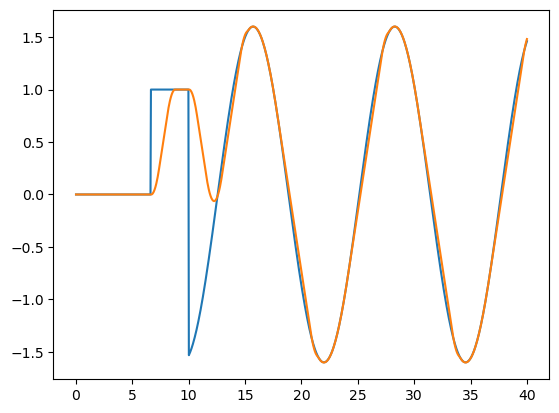

In [13]:
plt.figure(9);
plt.plot(time,target);
plt.plot(time,y);

## Starting finishing with non-zero velocity


You in fact specify a line in state space.  When you specify a target with non-zero velocity, the time at which you want to reach a certain point becomes important.


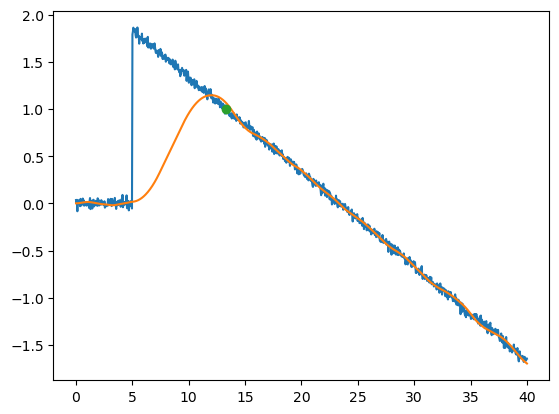

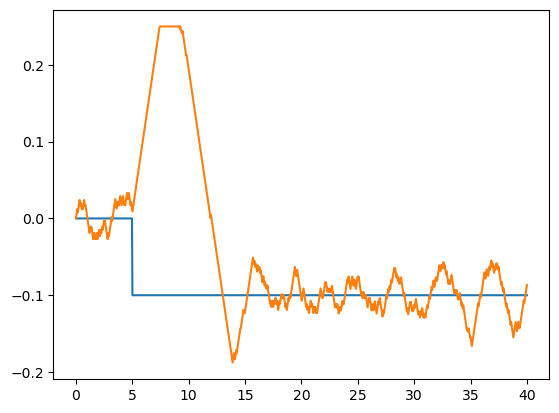

In [14]:
target2  = np.zeros((N,)); 
targetvel = -0.1
target2[N//8:] = 1.0 + (time[N//8:]-time[N//3])*targetvel
target2d = np.zeros((N,)); 
target2d[N//8:] = targetvel
target2 = target2 + np.random.randn(N)*0.03
maxvel2 = 0.25
maxacc2 = 0.1
y2 = np.zeros((N,))
y2d = np.zeros((N,))
u2  = np.zeros((N,))
for i in range(N-1):
    y2[i+1], y2d[i+1], u2[i] = transientprofilegenerator(y2[i],y2d[i],target2[i],target2d[i], maxvel2, maxacc2, dt );
plt.figure(12);
plt.plot(time,target2);
plt.plot(time,y2);
plt.plot(time[N//3],1.0,'o')
plt.figure(13);
plt.plot(time,target2d);
plt.plot(time,y2d);

## Generating a transient profile for a signal sampled at lower frequency

In [15]:
def subsample(a, n):
    N = a.shape[0]
    M = N//n;
    result = a.copy();
    for i in range(M):
        value = a[i*n]
        result[i*n : i*n +n] = value
    return result

def subsample_with_gradient(a,ad, dt,n):
    N = a.shape[0]
    M = N//n;
    result = a.copy();
    resultd = a.copy();
    interv = np.arange(0,n)*dt;
    for i in range(M):
        value = a[i*n]
        deriv = ad[i*n];
        result[i*n : i*n +n] = value + deriv*interv
        resultd[i*n : i*n+n] = deriv
    return result,resultd


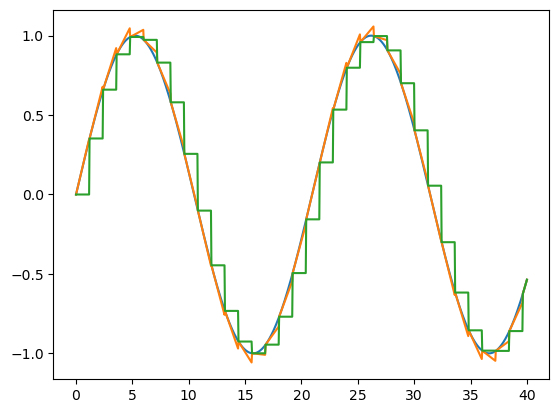

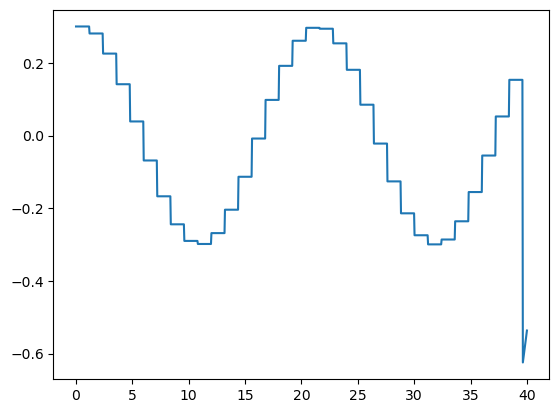

In [16]:
target2  = np.zeros((N,)); 
target2d = np.zeros((N,));
target2  = np.sin(0.3*time) #+ np.random.randn(N)*0.03
target2d = 0.3*np.cos(0.3*time) #+ np.random.randn(N)*0.03;

target3,target3d = subsample_with_gradient(target2,target2d,dt,30)
target4 = subsample(target2,30)
plt.figure(17);
plt.plot(time,target2);
plt.plot(time,target3)
plt.plot(time,target4)
plt.figure(18);
plt.plot(time,target3d);

In [17]:
#target2 = target2 + np.random.randn(N)*0.03
maxvel2 = 0.35
maxacc2 =  0.4
y2 = np.zeros((N,))
y2d = np.zeros((N,))
u2  = np.zeros((N,))
for i in range(N-1):
    y2[i+1], y2d[i+1], u2[i] = transientprofilegenerator(y2[i],y2d[i],target3[i],target3d[i],maxvel2, maxacc2, dt );

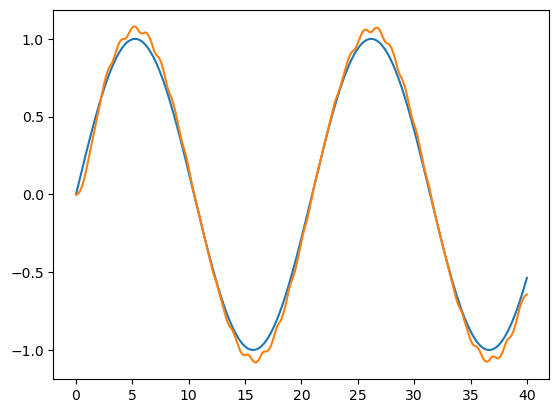

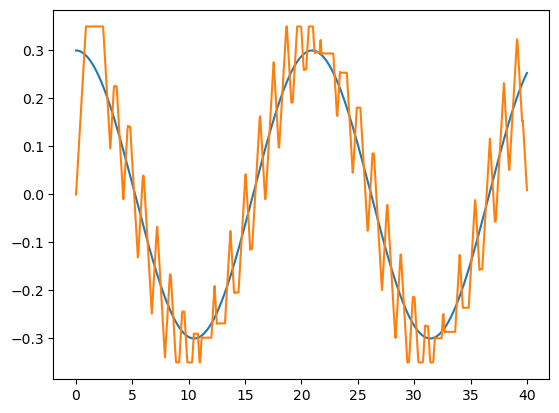

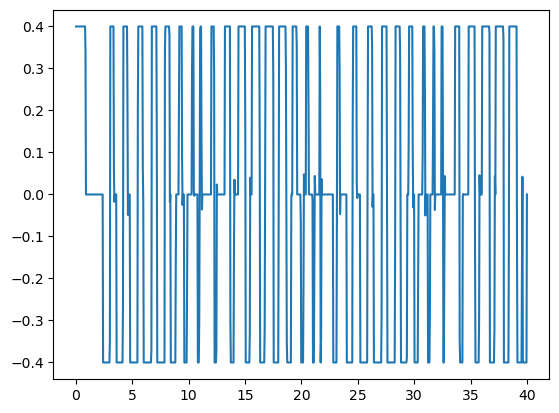

In [18]:
plt.figure(14);
plt.plot(time,target2);
plt.plot(time,y2);
plt.figure(15);
plt.plot(time,target2d);
plt.plot(time,y2d);
plt.figure(16);
plt.plot(time,u2)

## Multiple joints

Synchronous motion, i.e. always going through the same path

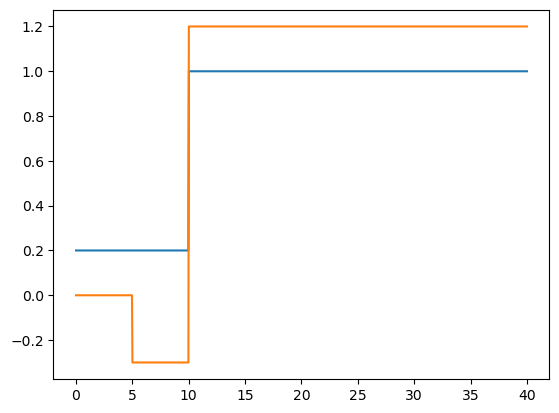

In [19]:
target2  = np.zeros((N,)); 
target2[:] = 0.2
target2[N//4:] = 1.0 
target2d = np.zeros((N,))
maxvel2 = 0.2
maxacc2 = 0.1

target3  = np.zeros((N,)); 
target3[:] = 0
target3[N//8:N//4] = -0.3
target3[N//4:] = 1.2
target3d = np.zeros((N,))
alpha = 0.8;
maxvel3 = maxvel2 * alpha
maxacc3 = maxacc2 *alpha


dt =time[1]-time[0]
plt.plot(time,target2);
plt.plot(time,target3)

In [20]:

    
def fst( x1,x2, r, h) :
    d  = r*h
    d0 = d*h
    y  = x1 + h*x2
    ya = math.fabs(y)
    a0 = math.sqrt( d*d + 8*r*ya ) 
    if ya > d0:
        a = x2 + (a0-d)/2*sgn(y)
    else:
        a = x2 + y / h
    if math.fabs(a) > d:
        return - r*sgn(a)
    else:
        return - r*a/d
    
def fst2( x1,x2, h) :
    " units s^2,  s , s"
    d  = h
    d0 = d*h
    y  = x1 + h*x2
    ya = math.fabs(y)
    a0 = math.sqrt( d*d + 8*ya ) 
    if ya > d0:
        a = x2 + (a0-d)/2*sgn(y)
    else:
        a = x2 + y / h
    if math.fabs(a) > d:
        return - sgn(a)
    else:
        return - a/d


def fst3( x1,x2) :
    " units s^2,  s , s"
    y  = x1 + x2
    ya = math.fabs(y)
    a0 = math.sqrt( 1 + 8*ya ) 
    if ya > 1:
        a = x2 + (a0-1)/2*sgn(y)
    else:
        a = x2 + y 
    if math.fabs(a) > 1:
        return - sgn(a)
    else:
        return - a

    
def transientprofilegenerator(y,yd, target, targetd, maxvel, maxacc, dt):
    """returns y,yd,u, the next y, yd and control signal (acceleration) u """
    u = fst( y - target, yd - targetd, maxacc, dt)
    u = fst2( (y - target)/maxacc, (yd - targetd)/maxacc, dt)*maxacc;
    #u = fst3( (y - target)/maxacc/dt, (yd - targetd)/maxacc/dt/dt ) * maxacc * dt*dt
    new_y  = y + yd * dt;
    new_yd = yd + u * dt; 
    #if new_yd <= - maxvel:
    #    u      = (-maxvel-yd)/dt;
    #    new_yd = -maxvel;
    #if new_yd >= maxvel:
    #    u = (maxvel-yd)/dt;
    #    new_yd = maxvel;
    return new_y, new_yd, u
    
    
    
    
    

In [21]:
y2 = np.zeros((N,))
y2d = np.zeros((N,))
u2  = np.zeros((N,))

y3 = np.zeros((N,))
y3d = np.zeros((N,))
u3  = np.zeros((N,))

    
for i in range(N-1):
    _,_,u2[i] = transientprofilegenerator(y2[i]/maxacc2,y2d[i]/maxacc2,target2[i]/maxacc2,target2d[i]/maxacc2, maxvel2/maxacc2, 1.0, dt );
    _,_,u3[i] = transientprofilegenerator(y3[i]/maxacc3,y3d[i]/maxacc3,target3[i]/maxacc3,target3d[i]/maxacc3, maxvel3/maxacc3, 1.0, dt );
    y2[i+1]  = y2[i]    + dt * y2d[i]
    y2d[i+1] = y2d[i] + dt* u2[i]*maxacc2
    y3[i+1]  = y3[i]    + dt * y3d[i]
    y3d[i+1] = y3d[i] + dt* u3[i]*maxacc3  

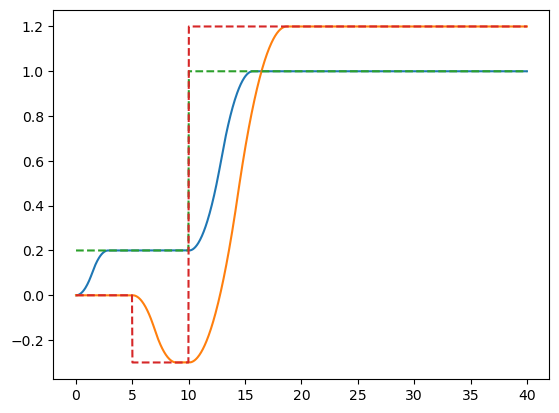

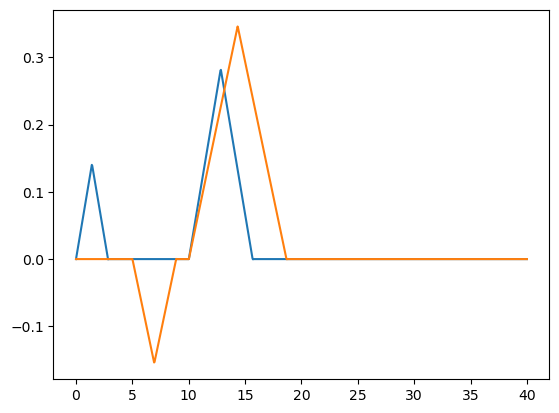

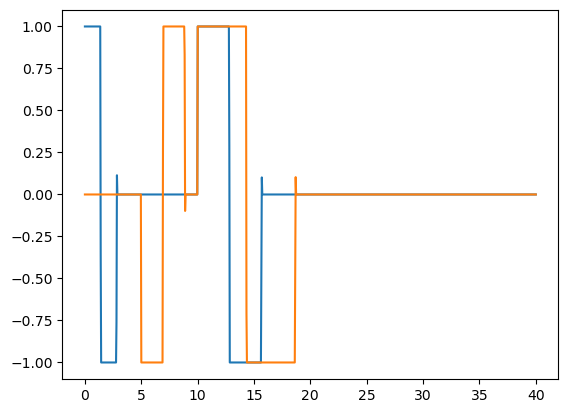

In [22]:
plt.figure()
plt.plot(time,y2)
plt.plot(time,y3)
plt.plot(time,target2,'--')
plt.plot(time,target3,'--')
plt.figure()
plt.plot(time,y2d)
plt.plot(time,y3d)
plt.figure()
plt.plot(time,u2)
plt.plot(time,u3)

## Scale invariance of parameters

Input : 
  - $x [m]$
  - $\dot{x} [m/s]$
  - $V \left[m/s\right]$
  - $A \left[m/s^2\right]$
  - $\Delta t [s]$
  
  \begin{align}
    y &= x+ \dot{x}\Delta t  & & [m]\\
    v_0 &= \sqrt{ A (\Delta t^2 + 8  |y|)} & & [m s^{-1}]\\
    v   &= \dot{x} + \frac{\text{sign}(y)}{2}(v_0-A \Delta t) & &\text{if} & |y| > A \Delta t^2 & & [m s^{-1}]\\
    v  &= \dot{x} + \frac{y}{\Delta t}              & &\text{if} & |y| \leq A \Delta t^2 & & [m s^{-1}]\\
    u  &= -\text{sign}(v) A                         & &\text{if} & |v| > A \Delta t & & [m s^{-2}]\\
    u  &= -\frac{v}{\Delta t}                  & &\text{if} & |v| \leq A \Delta t & & [m s^{-2}]
  \end{align}

In [23]:

def fst( x1,x2, r, h) :
    d  = r*h
    d0 = d*h
    y  = x1 + h*x2
    ya = math.fabs(y)
    a0 = math.sqrt( d*d + 8*r*ya ) 
    if ya > d0:
        a = x2 + (a0-d)/2*sgn(y)
    else:
        a = x2 + y / h
    if math.fabs(a) > d:
        return - r*sgn(a)
    else:
        return - r*a/d

\begin{align}
\Delta x &= \frac{a \Delta t^2}{2} \\
\Delta v &= a \Delta t \\
\Delta t &= \sqrt{\frac{2\Delta x}{a}}\\
\Delta v &= a \sqrt{\frac{2\Delta x}{a}} = \sqrt{2 a \Delta x} \\
\end{align}
sdf
\begin{align}
    y &= x+ \dot{x}\Delta t  & & [m]\\
    t_0 &= \sqrt{ \frac{\Delta t^2}{A} + \frac{8  |y|}{A}} & & [s]\\
    v   &= \dot{x} + \frac{\text{sign}(y)}{2} A (t_0- \Delta t) & &\text{if} & |y| > A \Delta t^2 & & [m s^{-1}]\\
    v  &= \dot{x} + \frac{y}{\Delta t}              & &\text{if} & |y| \leq A \Delta t^2 & & [m s^{-1}]\\
    u  &= -\text{sign}(v) A                         & &\text{if} & |v| > A \Delta t & & [m s^{-2}]\\
    u  &= -\frac{v}{\Delta t}                  & &\text{if} & |v| \leq A \Delta t & & [m s^{-2}]
\end{align}


Limit $\Delta t \rightarrow 0$:
\begin{align}
    t_0 &= \sqrt{  \frac{8  |x|}{A}} & & [s]\\
    v   &= \dot{x} + \frac{\text{sign}(y)}{2} A (t_0) & &[m s^{-1}]\\
    u  &= -\text{sign}(v) A                         & & [m s^{-2}]
\end{align}
Further adapted:
\begin{align}
    t_0 &= \sqrt{  \frac{2 |x|}{A}} & & [s]\\
    v   &= \dot{x} + \text{sign}(y) A t_0 & &[m s^{-1}]\\
    u  &= -\text{sign}(v) A                         & & [m s^{-2}]
\end{align}
Even more simplified:
\begin{align}
    v_0 &= \sqrt{  2 |x|A} & & [s] \text{~~~Velocity magnitude achieved by accelerating maximally over~} \Delta x\\
    v   &= \dot{x} + \text{sign}(x) v_0 & &[m s^{-1}]\\
    u  &= -\text{sign}(v) A                         & & [m s^{-2}]
\end{align}

In [34]:
fst(0.01/1000,0/1000,3/1000,0.1)*1000

-1.0

In [35]:
fst(0.01,0,3,0.1)

-0.9999999999999998